# Keypoint Detection using Mask R-CNN

In this notebook, we will introduce keypoint detection.  Keypoints are meaningful points of an object detected in an image.  For example, facial or body keypoint detection can be used for emotion and pose recognition.   We will demostrate how to do human body keypoints detection using the pretrained Keypoint R-CNN model in PyTorch.  The Keypoint R-CNN is described in [Mask R-CNN](https://arxiv.org/abs/1703.06870) as well.

## Initialization

In [ ]:
# imports
from PIL import Image
import matplotlib.pyplot as plt
import scrapbook as sb
import urllib.request

# torch
import torch
import torchvision

# utility
import sys
sys.path.append("../../")

from utils_cv.common.data import data_path, unzip_url
from utils_cv.common.gpu import is_windows, which_processor
from utils_cv.detection.data import Urls, coco_labels
from utils_cv.detection.dataset import DetectionDataset
from utils_cv.detection.model import DetectionLearner, get_pretrained_keypointrcnn
from utils_cv.detection.plot import plot_detections, PlotSettings


# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend("TkAgg")

print(f"TorchVision: {torchvision.__version__}")
which_processor()

In [2]:
# ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Next, set some model runtime parameters.

In [3]:
DATA_PATH = unzip_url(Urls.fridge_objects_keypoint_path, exist_ok=True)
EPOCHS = 10
THRESHOLD = 0.5  # discard all detections with confidence score below this threshold
IM_SIZE = 500

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using torch device: {device}")

Using torch device: cuda


## Prediction with Pre-trained Model

### Preparation

We will use an image from the Internet.

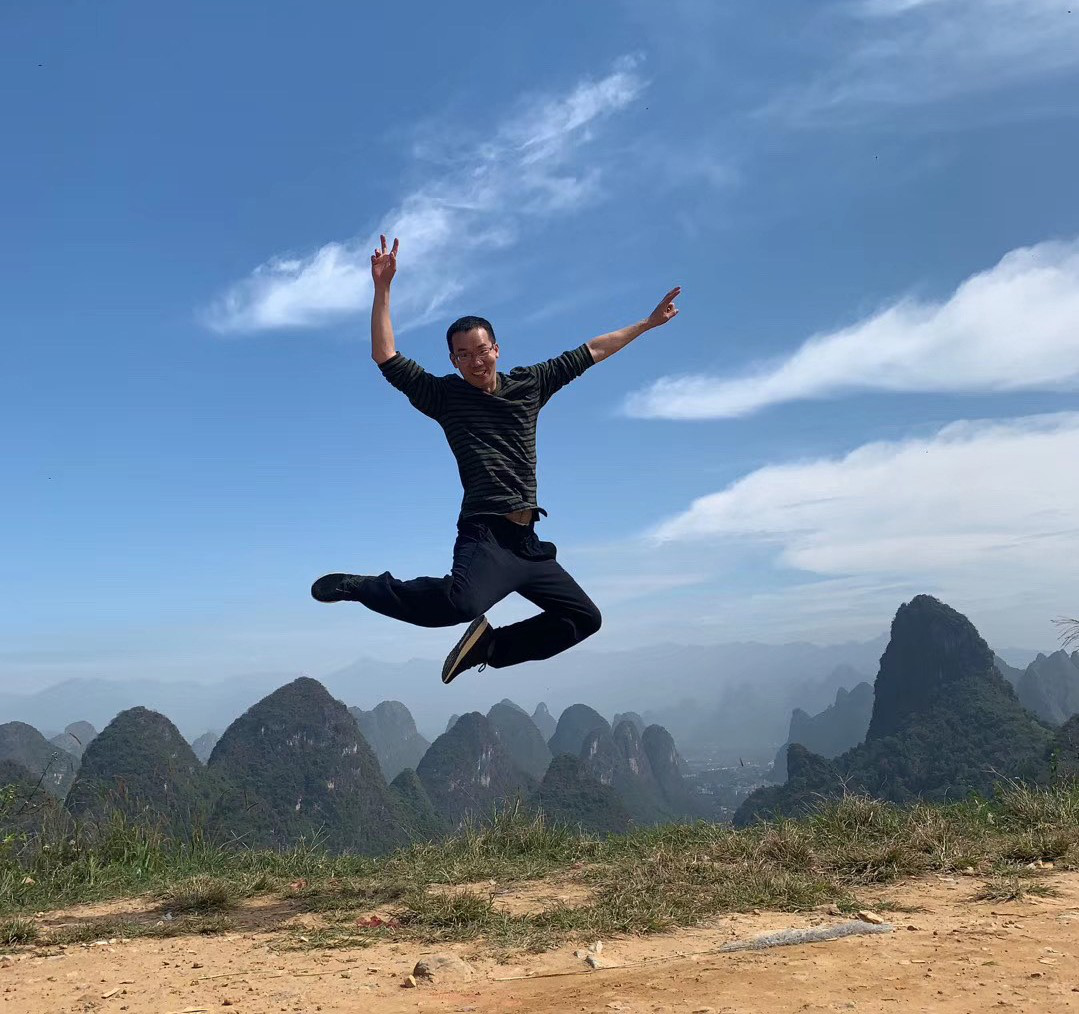

In [4]:
# download image
img_url = "https://cvbp.blob.core.windows.net/public/datasets/object_detection/keypoint_detection.jpg"
img_path = data_path() / img_url.split('/')[-1]
urllib.request.urlretrieve(img_url, img_path)

# show image
Image.open(img_path)

Similar to [01_training_introduction notebook](https://render.githubusercontent.com/view/01_training_introduction.ipynb), we can use `get_pretrained_keypointrcnn()` to get the pretrained Keypoint R-CNN model in PyTorch to create a `DetectionLearner`.

In [5]:
# get pretrained keypoint rcnn model
person_detector = DetectionLearner(
    model=get_pretrained_keypointrcnn(min_size=IM_SIZE, max_size=IM_SIZE),
    labels=coco_labels()[1:],
    device=device,
)

The pretrained model is built on the [COCO train2017 dataset (118K/18GB)](http://images.cocodataset.org/zips/train2017.zip) with 17 annotated human body keypoints.

In [6]:
keypoint_labels = [
    'nose',
    'left_eye',
    'right_eye',
    'left_ear',
    'right_ear',
    'left_shoulder',
    'right_shoulder',
    'left_elbow',
    'right_elbow',
    'left_wrist',
    'right_wrist',
    'left_hip',
    'right_hip',
    'left_knee',
    'right_knee',
    'left_ankle',
    'right_ankle',
]

Keypoints of an object can be connected by edges in some order for visualization.

In [7]:
keypoint_skeleton = [
    [15, 13],
    [13, 11],
    [16, 14],
    [14, 12],
    [11, 12],
    [5, 11],
    [6, 12],
    [5, 6],
    [5, 7],
    [6, 8],
    [7, 9],
    [8, 10],
    [1, 2],
    [0, 1],
    [0, 2],
    [1, 3],
    [2, 4],
    [3, 5],
    [4, 6],
]

### Prediction

The results from `DetectionLearner.predict()` is a `Dict` contains `det_bboxes` and `keypoints`.

In [8]:
# predict
pred = person_detector.predict(img_path, threshold=THRESHOLD)
pred["det_bboxes"]

[{Bbox object: [left=323, top=239, right=662, bottom=673] | <person> | label:1 | path:/home/simon/Copy/Projects/work/vb/cvbp/repo/fork-cvbp/data/keypoint_detection.jpg} | score: 0.9998908042907715]

A keypoint is represented by its x and y coordinate as well as visibility in the image.  `0` means invisible.

In [9]:
pred["keypoints"]

array([[[473.2162 , 356.5088 ,   1.     ],
        [479.68228, 347.8616 ,   1.     ],
        [462.43942, 350.02338,   1.     ],
        [494.76978, 350.02338,   1.     ],
        [451.66263, 356.5088 ,   1.     ],
        [524.94476, 386.77402,   1.     ],
        [445.19656, 399.74484,   1.     ],
        [587.4501 , 354.347  ,   1.     ],
        [384.8466 , 356.5088 ,   1.     ],
        [645.6447 , 324.08176,   1.     ],
        [380.53586, 293.8165 ,   1.     ],
        [522.78937, 540.262  ,   1.     ],
        [481.83765, 540.262  ,   1.     ],
        [578.8286 , 618.0869 ,   1.     ],
        [462.43942, 602.9543 ,   1.     ],
        [496.92514, 648.3521 ,   1.     ],
        [365.44836, 587.82166,   1.     ]]], dtype=float32)

### Visualization

Likewise, we can use `plot_detections()` to visulize the predicted bounding boxes and keypoints.  It needs an additional parameter `keypoint_meta` to indicate how to connect the keypoints with edges.

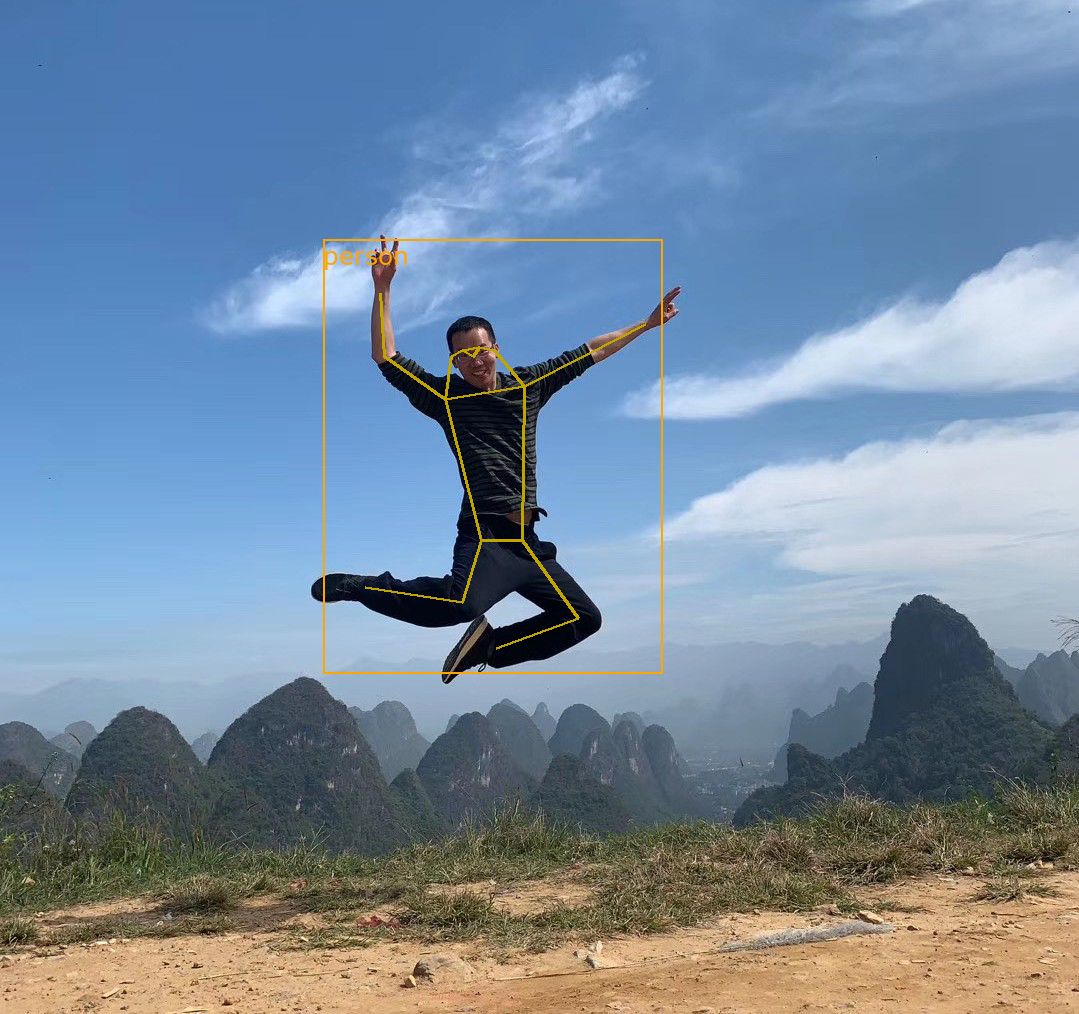

In [10]:
# plot
plot_detections(pred, keypoint_meta={"skeleton": keypoint_skeleton})

## Tuning with Custom Dataset

### Browse and Prepare the Dataset

We are going to use the odFridgeObjectsKeypoint datasets for illustration. The dataset has already downloaded and unzipped into `DATA_PATH`. This dataset includes 30 images of 4 class labels: `can`, `carton`, `milk_bottle` and `water_bottle`.

```
odFridgeObjectsKeypoints/
├── annotations
│   ├── 1.xml
│   ├── 2.xml
│   ├── ...
│   ├── 29.xml
│   └── 30.xml
└── images
    ├── 1.jpg
    ├── 2.jpg
    ├── ...
    ├── 29.jpg
    └── 30.jpg
```

The `images` directory contains original images. The annotations in the `annotations` directory are of format [PASCAL VOC](http://host.robots.ox.ac.uk/pascal/VOC/) shown as in [01_training_introduction notebook](01_training_introduction.ipynb).  The difference in the annotations from [01_training_introduction notebook](01_training_introduction.ipynb) is the additional information on keypoints.

```xml
<annotation>
        <folder>images</folder>
        <filename>100.jpg</filename>
        <path>../images/100.jpg</path>
        <source>
                <database>Unknown</database>
        </source>
        <size>
                <width>499</width>
                <height>666</height>
                <depth>3</depth>
        </size>
        <segmented>0</segmented>
        <object>
                <name>can</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>130</xmin>
                        <ymin>271</ymin>
                        <xmax>367</xmax>
                        <ymax>467</ymax>
                </bndbox>
                <keypoints>
                        <left_collar>
                                <x>142</x>
                                <y>349</y>
                        </left_collar>
                        <right_collar>
                                <x>186</x>
                                <y>278</y>
                        </right_collar>
                        <left_shoulder>
                                <x>152</x>
                                <y>371</y>
                        </left_shoulder>
                        <right_shoulder>
                                <x>206</x>
                                <y>277</y>
                        </right_shoulder>
                        <left_bottom>
                                <x>276</x>
                                <y>455</y>
                        </left_bottom>
                        <right_bottom>
                                <x>343</x>
                                <y>339</y>
                        </right_bottom>
                </keypoints>
        </object>
</annotation>
```

To load the data, we need to create a Dataset object class that Torchvision knows how to use.  To make it more convinient, we've created a `DetectionDataset`class that knows how to extract annotation information from the Pascal VOC format and meet the requirements of the Torchvision dataset object class.  There is an additional parameter `keypoint_meta` for specifying the meta data for the keypoints we are going to predict.  The keypoints meta data should be a dict that contains `category`, `labels`, `skeleton` and `hflip_inds`.  `category` is the category of the objects we are going to do keypoint detetion, `labels` is the names of the keypoints, `skeleton` defines the relationship among the keypoints, and `hflip_inds` indicates the order of keypoints when the image being flipped.

In odFridgeObjectsKeypoint, we defined 6 keypoints for milk bottle.

In [11]:
milkbottle_meta = {
    "category": "milk_bottle",
    "skeleton": [
        [0, 1],
        [0, 2],
        [1, 3],
        [2, 3],
        [2, 4],
        [3, 5],
        [4, 5],
    ],
    "labels": [
        'lid_left_top',
        'lid_right_top',
        'lid_left_bottom',
        'lid_right_bottom',
        'left_bottom',
        'right_bottom',
    ],
    # left becomes right when flipped horizontally
    "hflip_inds": [1, 0, 3, 2, 5, 4],
}

There are 85 images containing milk bottle.


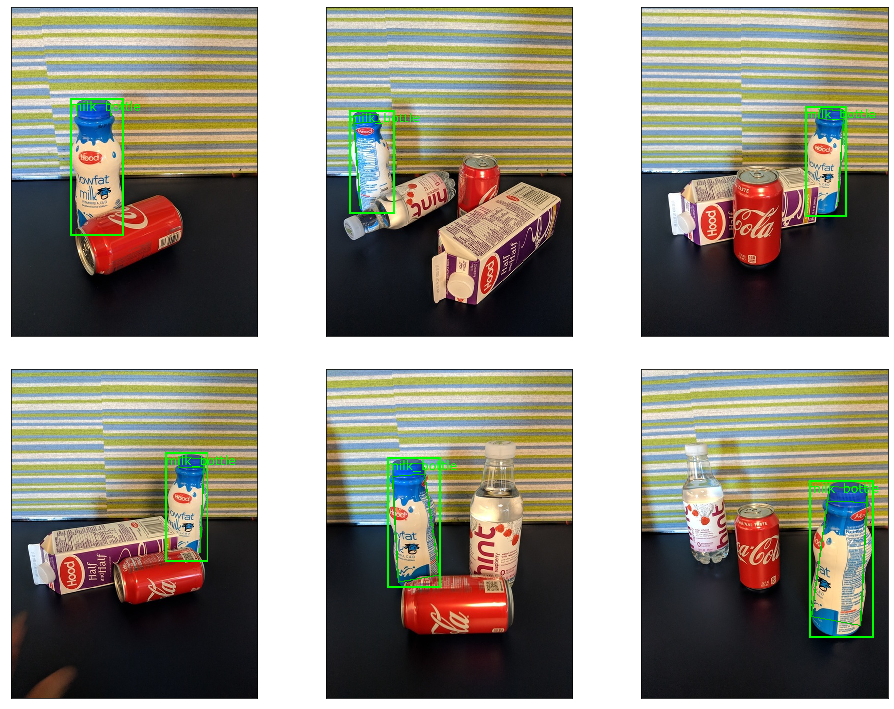

In [12]:
milkbottles = DetectionDataset(
    root=DATA_PATH, 
    keypoint_meta = milkbottle_meta
)
print(f"There are {len(milkbottles)} images containing milk bottle.")
milkbottles.show_ims(rows=2, seed=168)

Now `DetectionDataset` collected all images containing milk bottle.

### Re-train

To tune the model, we need to specify the number of keypoints in `get_pretrained_keypointrcnn()` and pass the dataset to `DetectionLearner` before calling its `.fit()` method.

In [13]:
# train
milkbottle_model = get_pretrained_keypointrcnn(
    num_classes=2,  # __background__ and milk_bottle
    num_keypoints=len(milkbottle_meta["labels"]),
)
milkbottle_detector = DetectionLearner(dataset=milkbottles, model=milkbottle_model, device=device)
milkbottle_detector.fit(epochs=EPOCHS, lr=0.005, print_freq=30, skip_evaluation=True)

Epoch: [0]  [ 0/22]  eta: 0:04:59  lr: 0.000243  loss: 8.7622 (8.7622)  loss_classifier: 0.6156 (0.6156)  loss_box_reg: 0.0817 (0.0817)  loss_keypoint: 8.0580 (8.0580)  loss_objectness: 0.0019 (0.0019)  loss_rpn_box_reg: 0.0051 (0.0051)  time: 13.6242  data: 0.7058  max mem: 0
Epoch: [0]  [21/22]  eta: 0:00:12  lr: 0.005000  loss: 7.5867 (7.4390)  loss_classifier: 0.1042 (0.2514)  loss_box_reg: 0.0823 (0.0885)  loss_keypoint: 7.3715 (7.0904)  loss_objectness: 0.0032 (0.0047)  loss_rpn_box_reg: 0.0033 (0.0041)  time: 12.7772  data: 0.0054  max mem: 0
Epoch: [0] Total time: 0:04:42 (12.8259 s / it)
Epoch: [1]  [ 0/22]  eta: 0:05:55  lr: 0.005000  loss: 4.6731 (4.6731)  loss_classifier: 0.0690 (0.0690)  loss_box_reg: 0.1030 (0.1030)  loss_keypoint: 4.4951 (4.4951)  loss_objectness: 0.0044 (0.0044)  loss_rpn_box_reg: 0.0017 (0.0017)  time: 16.1519  data: 1.7520  max mem: 0
Epoch: [1]  [21/22]  eta: 0:00:12  lr: 0.005000  loss: 2.8338 (3.7172)  loss_classifier: 0.0640 (0.0694)  loss_box_reg

### Prediction

Now we will do keypint detection on the first milk bottle image.

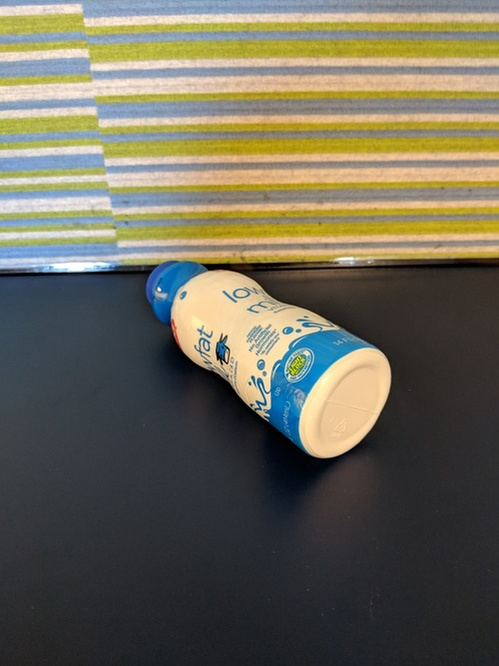

In [52]:
milkbottle_path = milkbottles.im_paths[1]
Image.open(milkbottle_path)

In [53]:
pred = milkbottle_detector.predict(milkbottle_path, threshold=THRESHOLD)
pred["det_bboxes"]

[{Bbox object: [left=128, top=263, right=416, bottom=458] | <milk_bottle> | label:1 | path:/home/simon/Copy/Projects/work/vb/cvbp/repo/fork-cvbp/data/odFridgeObjectsKeypoint/images/105.jpg} | score: 0.9870762228965759]

In [54]:
pred["keypoints"]

array([[[147.82036, 301.221  ,   1.     ],
        [167.75444, 263.24286,   1.     ],
        [152.80388, 301.221  ,   1.     ],
        [194.54088, 263.24286,   1.     ],
        [310.40778, 457.49176,   1.     ],
        [380.17706, 351.0284 ,   1.     ]]], dtype=float32)

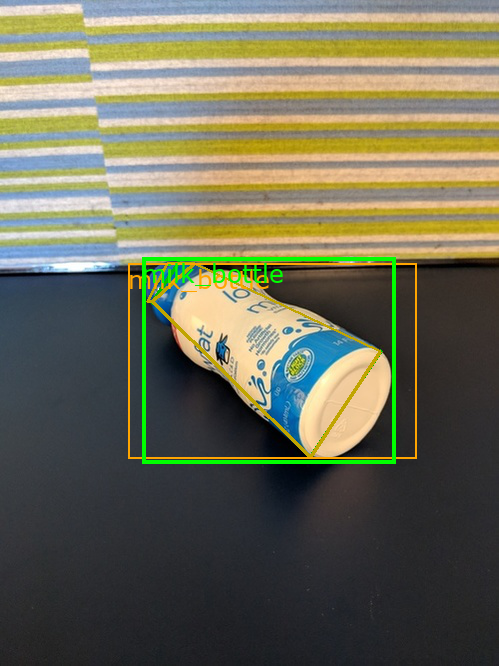

In [59]:
plot_detections(pred, milkbottles, idx=1, keypoint_meta=milkbottle_meta)

In [ ]:
# preserve some of the notebook outputs
sb.glue("keypoints", pred["keypoints"].tolist())
sb.glue("bboxes", [str(x) for x in pred["det_bboxes"]])

## Conclusion

In this notebook, we used the pretrained Keypoint R-CNN model extended from Mask R-CNN to detect keypoints, and demostrated how to tune the model for keypoint detection on custom dataset.